# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv', index_col='DATE', parse_dates=True)

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


<AxesSubplot:xlabel='DATE'>

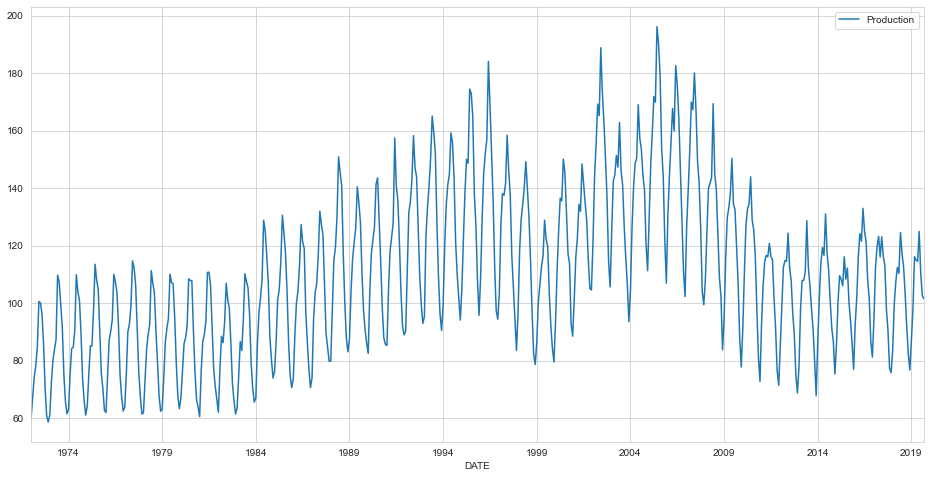

In [7]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [8]:
test_size = 24

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [16]:
X, y = generator[0]

In [17]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
n_features = train_scaled.shape[1]

### Creating Model

### with "tanh" activation function

In [20]:
model = Sequential()
model.add(LSTM(64, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(16, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [23]:
model.fit_generator(generator,epochs = 20,validation_data = validation_generator,callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 12s 15ms/step - loss: 0.0249 - val_loss: 0.0038
Epoch 2/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0140 - val_loss: 0.0019
Epoch 3/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 4/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 5/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 6/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 7/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 8/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0048 - val_loss: 0.0022


<AxesSubplot:>

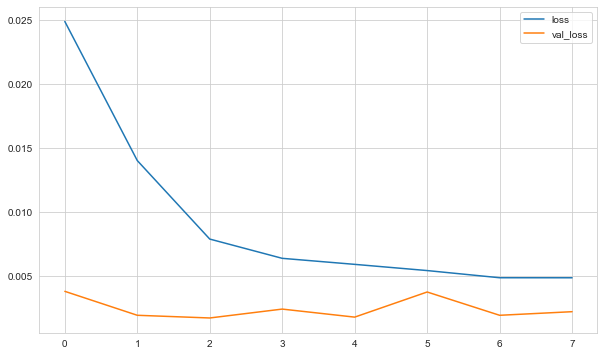

In [24]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [26]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [27]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

#### Inverse Transformations and Comparing

In [28]:
predictions = scaler.inverse_transform(predictions_scaled)

In [29]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

,Production,Predictions_tanh
DATE,,
2017-10-01,90.473,93.701
2017-11-01,77.438,85.632
2017-12-01,75.812,87.609
2018-01-01,83.434,98.491
2018-02-01,99.490,108.338
2018-03-01,107.315,112.909
2018-04-01,112.431,115.722
2018-05-01,110.354,116.747
2018-06-01,124.584,119.248


<AxesSubplot:xlabel='DATE'>

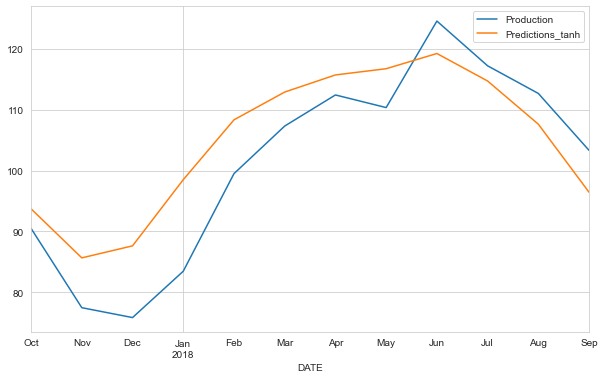

In [30]:
compare.plot()

In [31]:
eval_metrics(compare.Production, compare.Predictions_tanh)

r2_score: 0.748222696540925 
mae: 6.848609167027473 
mse: 59.37429645074288 
rmse: 7.705471851271853


#### Calculation R2 Score and Error Metrics

### with "relu" activation function

In [32]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [34]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [35]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 8s 11ms/step - loss: 0.0350 - val_loss: 0.0047
Epoch 2/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0139 - val_loss: 0.0024
Epoch 3/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0089 - val_loss: 0.0022
Epoch 4/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 5/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 6/20
537/537 [==============================] - 6s 10ms/step - loss: 0.0065 - val_loss: 0.0013
Epoch 7/20
537/537 [==============================] - 6s 10ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 8/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 9/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 10/20
537/537 [==============================] - 6s 10ms/step - loss: 0.0070 - val_lo

<AxesSubplot:>

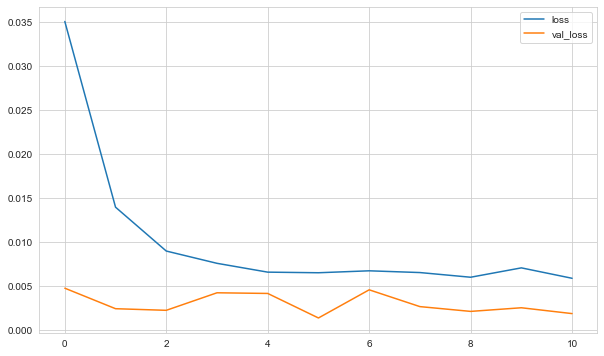

In [36]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [37]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

#### Inverse Transformations and Comparing

In [38]:
predictions = scaler.inverse_transform(predictions_scaled)

In [39]:
compare['Predictions_relu'] = predictions
compare

,Production,Predictions_tanh,Predictions_relu
DATE,,,
2017-10-01,90.473,93.701,101.783
2017-11-01,77.438,85.632,88.420
2017-12-01,75.812,87.609,87.030
2018-01-01,83.434,98.491,101.293
2018-02-01,99.490,108.338,113.619
2018-03-01,107.315,112.909,118.945
2018-04-01,112.431,115.722,119.027
2018-05-01,110.354,116.747,118.435
2018-06-01,124.584,119.248,120.718


<AxesSubplot:xlabel='DATE'>

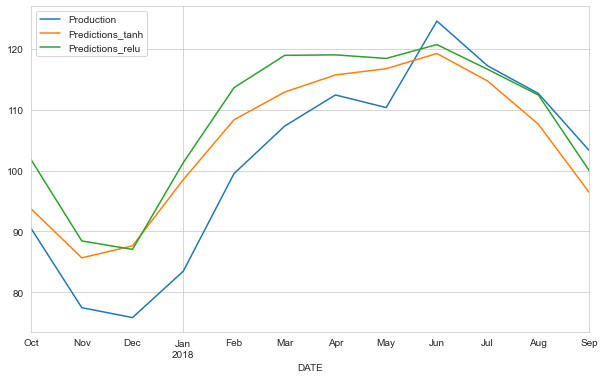

In [40]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [41]:
eval_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.5889600682875185 
mae: 8.316058883956567 
mse: 96.93171871847026 
rmse: 9.845390734677332


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [42]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [43]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [44]:
model = Sequential()
model.add(LSTM(64, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(16, activation = 'tanh'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
561/561 [==============================] - 11s 12ms/step - loss: 0.0250
Epoch 2/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0147
Epoch 3/10
561/561 [==============================] - 6s 11ms/step - loss: 0.0103
Epoch 4/10
561/561 [==============================] - 6s 12ms/step - loss: 0.0077
Epoch 5/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0058
Epoch 6/10
561/561 [==============================] - 6s 11ms/step - loss: 0.0056
Epoch 7/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0053
Epoch 8/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0048
Epoch 9/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0050
Epoch 10/10
561/561 [==============================] - 7s 12ms/step - loss: 0.0045


In [45]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [46]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[ 85.47606481],
       [ 79.03772961],
       [ 81.14666012],
       [ 89.65651101],
       [ 98.80955916],
       [106.93669241],
       [112.01924383],
       [116.282919  ],
       [117.86821821],
       [112.95934583],
       [106.037917  ],
       [ 96.34812729]])

In [47]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [48]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [49]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,85.476
2019-11-01,79.038
2019-12-01,81.147
2020-01-01,89.657
2020-02-01,98.810
2020-03-01,106.937
2020-04-01,112.019
2020-05-01,116.283
2020-06-01,117.868
2020-07-01,112.959


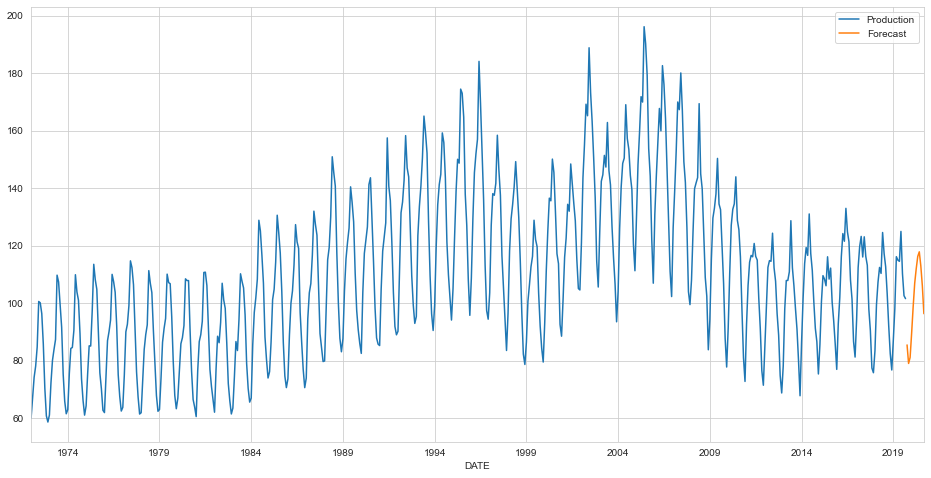

In [50]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

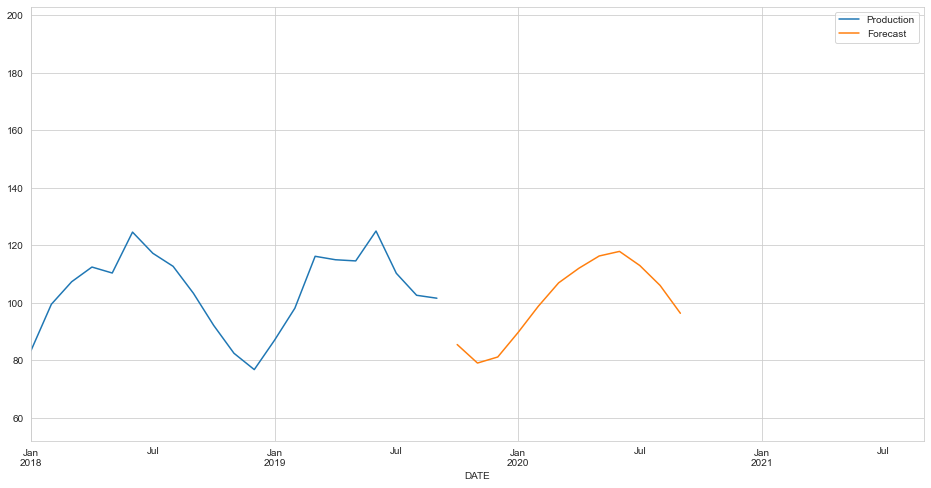

In [51]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')